In [1]:
import pandas as pd
from dotenv import load_dotenv

from pydantic import BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI

from api_helpers.clients import get_postgres_client


load_dotenv(
    dotenv_path="/Users/tomwattley/App/racing-api-project/racing-api-project/libraries/api-helpers/src/api_helpers/.env"
)

# pg = get_postgres_client()

2025-09-23T18:14:29Z | INFO - Logging configuration initialized with level: INFO


True

In [2]:
import numpy as np

In [3]:
np.random.choice(1, 1, ["a", "b"])

array([0])

In [4]:
import numpy as np

choices = ["a", "b"]
probs_pct = np.array([60, 40])  # e.g., 60% and 40%

p = probs_pct / 100  # or: p = probs_pct / probs_pct.sum()

# one sample
sample = np.random.choice(choices, p=p)

# N samples
samples = np.random.choice(choices, size=1, p=p)
print(samples)

['b']


In [11]:
# single float in [6, 16)
def return_random_price_data(max_edge):
    x = round(np.random.uniform(6.0, 16.0), 2)
    implied_chance = round(1 / x * 100, 2)
    random_edge = np.random.uniform(2, max_edge)
    actual_chance = implied_chance + random_edge
    return x, implied_chance, round(actual_chance, 2)


bets = []
for i in range(1000):
    price, implied_chance, actual_chance = return_random_price_data(5)
    choices = ["win", "loss"]
    probs_pct = np.array([actual_chance, 100 - actual_chance])  # e.g., 60% and 40%

    # one sample
    sample = np.random.choice(choices, p=probs_pct / 100)
    if sample == "win":
        profit = 0.8 * (price - 1)
        bets.append(profit)
    else:
        bets.append(-1)

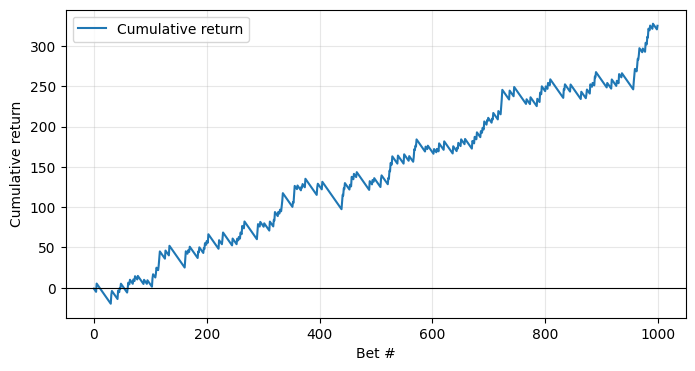

In [12]:
import numpy as np
import matplotlib.pyplot as plt

cum_returns = np.cumsum(bets)

plt.figure(figsize=(8, 4))
plt.plot(cum_returns, label="Cumulative return")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Bet #")
plt.ylabel("Cumulative return")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [52]:
sum(bets)

364.7200000000001

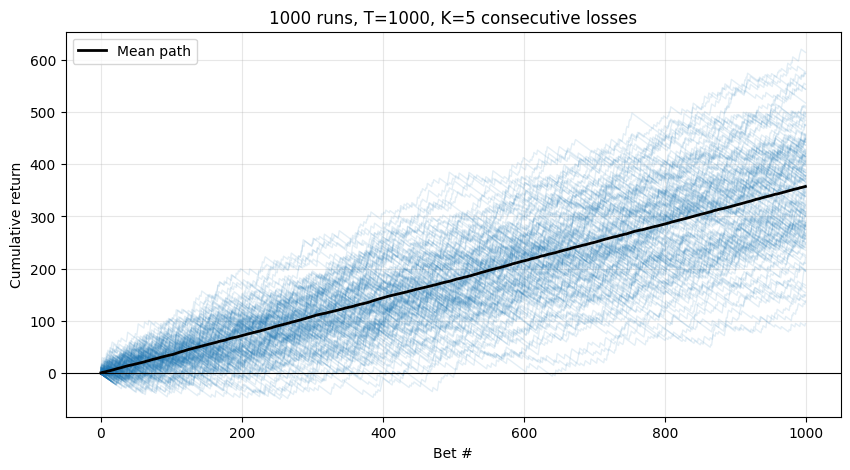

Runs with >= 5 consecutive losses: 1000 / 1000 (100.0%)
Total number of >= 5-loss streaks across all runs: 66916
Longest loss streak — mean: 32.16, median: 31.0, 95th pct: 45.0


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby

# Uses your existing return_random_price_data(max_edge)


def simulate_once(T=1000, max_edge=10):
    bets = np.empty(T, dtype=float)
    for t in range(T):
        price, _, actual_chance = return_random_price_data(max_edge)
        win = np.random.random() < (actual_chance / 100.0)
        bets[t] = 0.8 * (price - 1.0) if win else -1.0
    return np.cumsum(bets), bets


def loss_streak_lengths(loss_mask: np.ndarray) -> np.ndarray:
    # lengths of consecutive True segments
    if loss_mask.size == 0:
        return np.array([], dtype=int)
    return np.array(
        [sum(1 for _ in g) for val, g in groupby(loss_mask) if val], dtype=int
    )


def simulate_many(N=1000, T=1000, max_edge=10, k=5):
    paths = np.empty((N, T), dtype=float)
    longest_loss_streaks = np.zeros(N, dtype=int)
    runs_with_k_or_more = 0
    total_k_or_more_streaks = 0

    for i in range(N):
        cum, bets = simulate_once(T=T, max_edge=max_edge)
        paths[i] = cum
        losses = bets < 0
        lengths = loss_streak_lengths(losses)
        if lengths.size:
            longest_loss_streaks[i] = lengths.max()
            runs_with_k_or_more += int((lengths >= k).any())
            total_k_or_more_streaks += int((lengths >= k).sum())

    return paths, longest_loss_streaks, runs_with_k_or_more, total_k_or_more_streaks


# Params
N = 1000  # number of runs
T = 1000  # bets per run
K = 5  # "ruin" streak length
MAX_EDGE = 10
np.random.seed(42)  # optional reproducibility

paths, longest_streaks, runs_with_K, total_K = simulate_many(
    N=N, T=T, max_edge=MAX_EDGE, k=K
)

# Plot: show a subset for clarity, plus the mean path
plt.figure(figsize=(10, 5))
show_n = min(150, N)
for i in range(show_n):
    plt.plot(paths[i], color="tab:blue", alpha=0.12, lw=1)
mean_path = paths.mean(axis=0)
plt.plot(mean_path, color="black", lw=2, label="Mean path")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Bet #")
plt.ylabel("Cumulative return")
plt.title(f"{N} runs, T={T}, K={K} consecutive losses")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Answer the "ruin of K losses" question
print(f"Runs with >= {K} consecutive losses: {runs_with_K} / {N} ({runs_with_K/N:.1%})")
print(f"Total number of >= {K}-loss streaks across all runs: {total_K}")
print(
    f"Longest loss streak — mean: {longest_streaks.mean():.2f}, "
    f"median: {np.median(longest_streaks)}, 95th pct: {np.percentile(longest_streaks, 95)}"
)